<div style="text-align: center;">

# **Mini Project: Simple Moving Average (SMA) Crossover Strategy**  
</div>


## Fetch Market Data

For this mini project, we will utilize an library called yfinance to obtain historical data from Yahoo Finance of the Apple Inc. (AAPL), which will serve as our dataset. 

In [7]:
import yfinance as yf

# Fetch Apple (AAPL) stock data from 2020-01-01 to 2021-01-01
stock_data = yf.download('AAPL', start='2020-01-01', end='2022-01-01')


[*********************100%***********************]  1 of 1 completed


### Apple Inc. Stock Price Dataset

The table below represents a stock price dataset for **Apple Inc. (AAPL).**  

#### Column Descriptions  
- **Date** → The trading date.  
- **Price (Close)** → The adjusted closing price, commonly used for analysis.  
- **High** → The highest price reached during the trading day.  
- **Low** → The lowest price recorded during the trading day.  
- **Open** → The price at which the stock opened for trading.  
- **Volume** → The total number of shares traded on that day.  
- **Ticker (AAPL)** → The stock symbol representing Apple Inc.  

In [9]:
stock_data.head()


Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2020-01-02,72.716072,72.776598,71.466812,71.721019,135480400
2020-01-03,72.009140,72.771768,71.783985,71.941351,146322800
2020-01-06,72.582901,72.621639,70.876068,71.127858,118387200
2020-01-07,72.241547,72.849224,72.021231,72.592594,108872000
2020-01-08,73.403656,73.706287,71.943766,71.943766,132079200


# Simple Moving Average (SMA) Crossover Strategy

- We will use pandas to calculate two moving averages (short-term and long-term)
- Then, we will implement a basic trading logic based on the crossover of these moving average:
     1. Buy when the short-term SMA crosses above the long-term SMA
     2. Sell when the short-term SMA crosses below the long-term SMA
        

In [137]:
import pandas as pd
import numpy as np

# First, we will flatten out the stock_data dataframe since it has a multiIndex column structure
if isinstance(stock_data.columns, pd.MultiIndex):
    stock_data.columns = stock_data.columns.droplevel(1)

# let's calculate SMAs using the 'Close' column
stock_data['SMA_short'] = stock_data['Close'].rolling(window=20).mean()
stock_data['SMA_long'] = stock_data['Close'].rolling(window=50).mean()

# Initialize Signal column
stock_data['Signal'] = 0

# Generate signals after 50 periods
stock_data.loc[stock_data.index[50:], 'Signal'] = np.where(
    stock_data.loc[stock_data.index[50:], 'SMA_short'] > stock_data.loc[stock_data.index[50:], 'SMA_long'], 1, -1
)

#np.where(condition, value_if_true, value_if_false)

# Calculate position changes
stock_data['Position'] = stock_data['Signal'].diff()
#.diff() -> difference between the current row and the previous row

#display the new dataframe to verify the new columns
stock_data.tail()

Price,Close,High,Low,Open,Volume,SMA_short,SMA_long,Signal,Position
Date,,,,,,,,,
2021-12-27,177.228806,177.317254,174.024874,174.044520,74919600,168.514298,156.788250,1,0.0
2021-12-28,176.206680,178.211606,175.459756,177.061729,79144300,169.450416,157.469550,1,0.0
2021-12-29,176.295166,177.523669,175.076485,176.246023,62348900,170.142309,158.119056,1,0.0
2021-12-30,175.135422,177.464674,175.027313,176.383585,59773000,170.802261,158.701991,1,0.0
2021-12-31,174.516296,176.147738,174.211615,175.027343,64062300,171.480888,159.262730,1,0.0


### Visualizing the Results

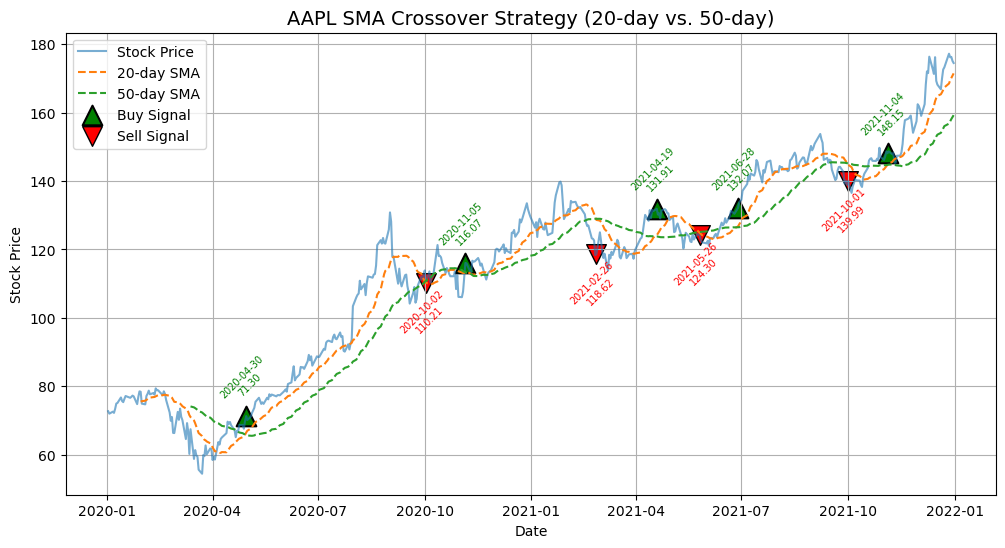

In [119]:
# Importing Matplotlib
import matplotlib.pyplot as plt

# Plot stock data and moving averages
plt.figure(figsize=(12, 6))
plt.plot(stock_data['Close'], label='Stock Price', alpha=0.6)
plt.plot(stock_data['SMA_short'], label='20-day SMA', linestyle='dashed')
plt.plot(stock_data['SMA_long'], label='50-day SMA', linestyle='dashed')

# Plot buy signals (↑)
buy_x = stock_data.index[stock_data['Position'] == 2]
buy_y = stock_data['Close'][stock_data['Position'] == 2]
plt.scatter(buy_x, buy_y, s=200, marker='^', color='green', edgecolors='black', linewidth=1.5, label='Buy Signal')

# Display date and price for Buy signals
for x, y in zip(buy_x, buy_y):
    plt.text(x, y + 3, f'{x.date()}\n{y:.2f}', fontsize=7, ha='center', color='green', rotation=45)  # Date + price, rotated


# Plot sell signals (↓)
sell_x = stock_data.index[stock_data['Position'] == -2]
sell_y = stock_data['Close'][stock_data['Position'] == -2]
plt.scatter(sell_x, sell_y, s=200, marker='v', color='red', edgecolors='black', linewidth=1, label='Sell Signal')

# Display date and price for Sell signals
for x, y in zip(sell_x, sell_y):
    plt.text(x, y - 17, f'{x.date()}\n{y:.2f}', fontsize=7, ha='center', color='red', rotation=45)  # Date + price, rotated

# Show the plot
plt.legend()
plt.grid()
plt.title('AAPL SMA Crossover Strategy (20-day vs. 50-day)', fontsize=14)
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.show()


### Backtest the SMA Strategy

- We will use Backtrader libary to simulate the performance of the trading strategy which is the simple moving average on the historical data of the Apple Inc. (AAPL)

In [155]:
# import backtrader library
import backtrader as bt

# creating a class for the simple moving average 
class MovingAverageStrategy(bt.Strategy):
    def __init__(self):
        # Define the short and long SMAs
        self.sma_short = bt.indicators.SimpleMovingAverage(self.data.close, period=50)
        self.sma_long = bt.indicators.SimpleMovingAverage(self.data.close, period=200)

    # the core of the trading logic 
    def next(self):
        if self.sma_short > self.sma_long and not self.position:  # Buy Signal
            self.buy()
        elif self.sma_short < self.sma_long and self.position:  # Sell Signal (close position)
            self.sell()  # Closing the position

# Next, we'll convert the data into Backtrader's PandasData format to ensure it is in the correct structure for processing.
data = bt.feeds.PandasData(dataname=stock_data)

# Initialize Backtrader
cerebro = bt.Cerebro()
cerebro.addstrategy(MovingAverageStrategy)
cerebro.adddata(data)

# Set the initial cash for the broker (optional, default is 1000)
initial_value = 10000
cerebro.broker.set_cash(initial_value)

# Run the strategy
cerebro.run()

final_value = cerebro.broker.getvalue()  # Final portfolio value

return_percentage = ((final_value - initial_value) / initial_value) * 100

# Printing the final portfolio value and ROI Percentage:
print(f'Final Portfolio Value: ${final_value:.2f}')
print(f'ROI Percentage: {return_percentage:.2f}%')



Final Portfolio Value: $10056.26
ROI Percentage: 0.56%


### Insights 

This analysis aimed to assess the effectiveness of the Simple Moving Average (SMA) crossover strategy on AAPL stock from January 2020 to January 2021. We utilized both the 20-day and 50-day SMAs to generate buy and sell signals.

The strategy operates on the principle that a buy signal is generated when the short-term SMA (20-day) crosses above the long-term SMA (50-day), which typically indicates a bullish trend and suggests an opportunity to buy early and capitalize on the upward momentum. Conversely, a sell signal occurs when the short-term SMA crosses below the long-term SMA, signaling a bearish trend and indicating the optimal time to sell before further price declines.

Starting with an initial investment of 10,000, the strategy generated a modest profit of 56.26 over the one-year period, resulting in a 0.56% return. While the strategy effectively identified market trends, its growth potential was limited by the overall market stability during the test period. Additionally, the relatively short duration of the dataset (one year) constrained the strategy's performance. The 20-day and 50-day SMAs are considered short-term indicators, which may not fully capture longer-term trends.

For instance, as shown in the graph, we bought AAPL at 131.91 on 2021-04-19 and sold it at 124.30 on 2021-05-26, resulting in a loss of 7.61 on that particular trade.

Although the SMA crossover strategy produced small gains, there is potential for improvement by incorporating additional indicators or implementing risk management strategies. Testing this approach in more volatile market conditions and over a longer period would offer a more comprehensive evaluation of the strategy's performance